In [30]:
using OITOOLS, PyPlot

In [2]:
# Simple limb-darkened disk fitting
# Check https://arxiv.org/abs/1610.06185 for published results

oifitsfile = "./data/AlphaCenA.oifits";

#
# LIMB DARKENED DISC FITTING
#

data = (readoifits(oifitsfile))[1,1];

# data can be split by wavelength/epochs for various purpose (e.g. polychromatic or dynamical imaging)
# Here we did not set any splitting
# Although OITOOLS will scold you for using non-compliant files (old VLTI), it will attempt fix them internally
# Here some stations are missing, which would prevent plotting - Unknown stations are introduced

┌ Warning: V2 table 2 refers to station index 6, non existent in OI_ARRAY=VLTI; available indexes are [1, 2, 3, 4]
└ @ OITOOLS ~/SOFTWARE/OITOOLS.jl/src/readoifits.jl:569
┌ Warning: V2 table 2 refers to station index 5, non existent in OI_ARRAY=VLTI; available indexes are [1, 2, 3, 4]
└ @ OITOOLS ~/SOFTWARE/OITOOLS.jl/src/readoifits.jl:569
┌ Warning: V2 table 3 refers to station index 6, non existent in OI_ARRAY=VLTI; available indexes are [1, 2, 3, 4]
└ @ OITOOLS ~/SOFTWARE/OITOOLS.jl/src/readoifits.jl:569
┌ Warning: V2 table 3 refers to station index 7, non existent in OI_ARRAY=VLTI; available indexes are [1, 2, 3, 4]
└ @ OITOOLS ~/SOFTWARE/OITOOLS.jl/src/readoifits.jl:569
┌ Warning: V2 table 4 refers to station index 6, non existent in OI_ARRAY=VLTI; available indexes are [1, 2, 3, 4]
└ @ OITOOLS ~/SOFTWARE/OITOOLS.jl/src/readoifits.jl:569
┌ Warning: V2 table 4 refers to station index 5, non existent in OI_ARRAY=VLTI; available indexes are [1, 2, 3, 4]
└ @ OITOOLS ~/SOFTWARE/OITOOLS

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


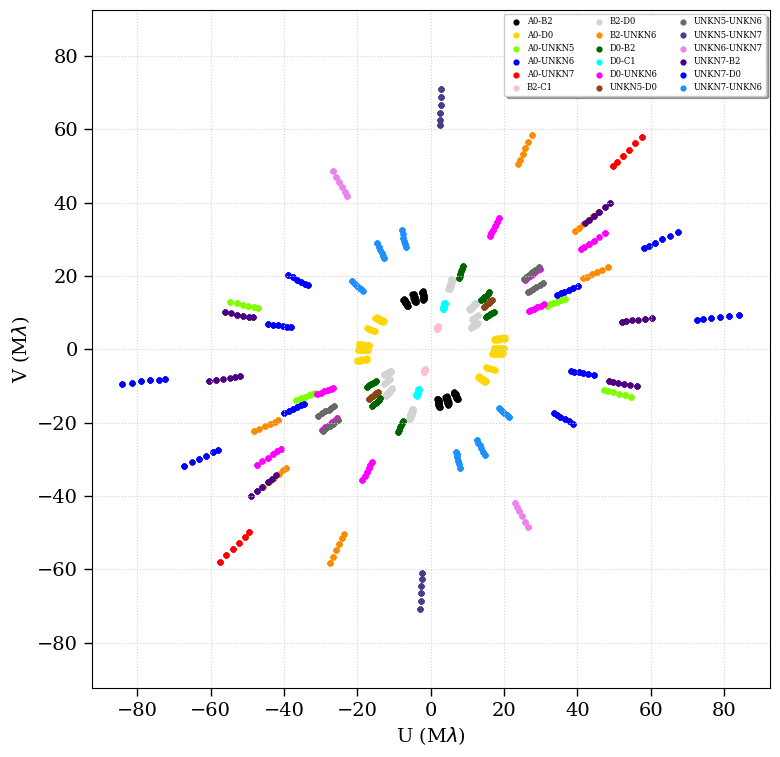

In [3]:
# Plotting uv coverage - no aerguments = sort by baseline
uvplot(data)

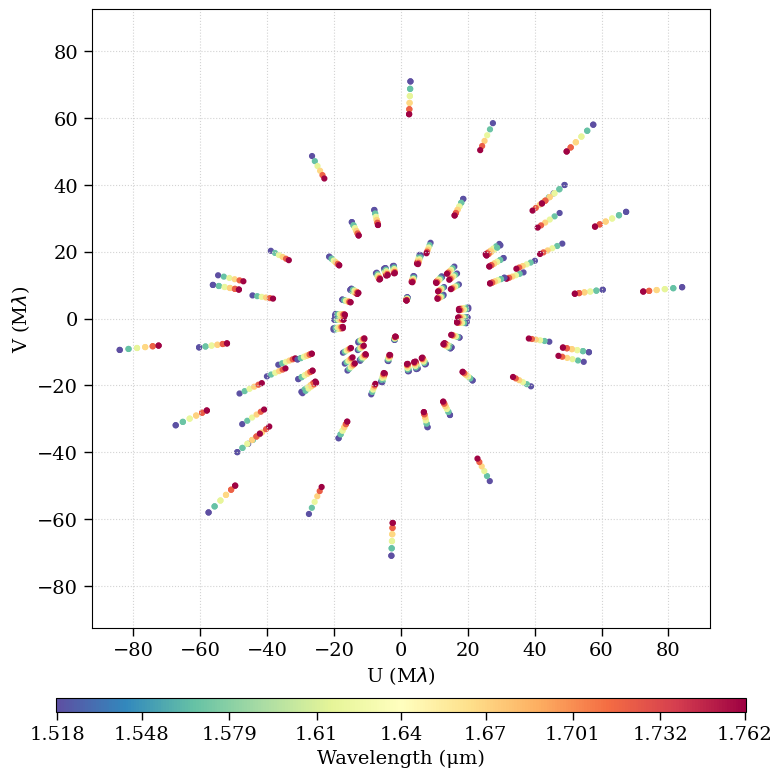

In [4]:
filter = set_data_filter(data, baseline_range=[0, 4e8])
data1 = filter_data(data, filter) # data1 is now filtered
uvplot(data1, color="wav")

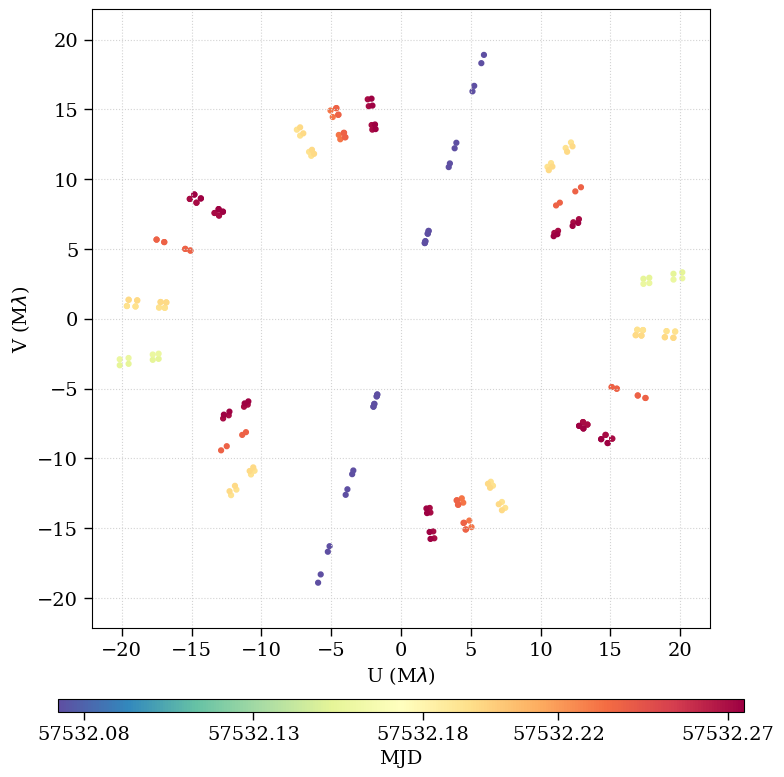

In [5]:
# One can define ranges of wavelengths, mjd, etc. to filter data 
# oifitslib (John Young's C library) can also be called to e.g. merge data sets or convert OIFITSv1 files into OIFITSv2 
filter = set_data_filter(data, wav_range=[[1.5e-6, 1.6e-6], [1.68e-6, 1.8e-6]], mjd_range=[57532.07, 57532.3])
data2 = filter_data(data, filter)
uvplot(data2, color="mjd")

# Can also filter "bad" data = flagged, NaN, nonsensical (errors<0 or enormous)
# Can also filter by SNR, etc.
# filter = set_data_filter(data, filter_bad_data=true)
# data3 = filter_data(data, filter)

In [48]:
# We can also prepare error bars "a la Monnier"
data2 = oifits_prep(data, min_v2_err_add = 0.0, min_v2_err_rel = 0.0 , v2_err_mult = 1.0, min_t3amp_err_add = 0.0,  min_t3amp_err_rel = 0.0, t3amp_err_mult = 1.0, min_t3phi_err_add = 0.0, t3phi_err_mult = 1.0);

In [6]:
disk = create_component(type="ldpow", name="Model");
# Our current interface (to be revised) uses known blocks:
#  "ud": Uniform disk
#  "ldlin": linear limb darkening
#  "ldquad": quadratic limb darkening
#  "ldquad_tri": quadratic law with "triangular sampling"
#  "ldpow": Hestroffer power law limbd darkening
#  "ldsqrt": sqrt limb darkening
#  "Gaussian": Gaussian
#   "ring": generic ring, can be skewed, thin, Gaussian or Lorentzian power law

In [50]:
# components are vectors of parameters and call 3 functions
# a visibility function, a positional function, a spectral function
disk.vis_params 

2-element Vector{OIparam}:
 OIparam("diameter", 1.0, 0.0, 40.0, 0.01, true)
 OIparam("α", 0.2, 0.0, 1.0, 0.01, true)

In [41]:
 # Each parameter is bounded (or can have a probability distribution) or a step for grid search
disk.vis_params[1]

OIparam
  name: String "diameter"
  val: Float64 1.0
  minval: Float64 0.0
  maxval: Float64 40.0
  step: Float64 0.01
  free: Bool true


In [42]:
# Here we have simply ra/dec but other schemes are possible (e.g. orbits or functions of time)
disk.pos_params

2-element Vector{OIparam}:
 OIparam("ra", 0.0, 0.0, 0.0, 0.01, false)
 OIparam("dec", 0.0, 0.0, 0.0, 0.01, false)

In [43]:
# Here we have a simple gray flux but black body and spectral lines are possible
# (interface coming Summer 2023)
disk.spectrum_params

1-element Vector{OIparam}:
 OIparam("flux", 1.0, 0.0, 1.0, 0.01, false)

In [7]:
# Models are created from one or several components
model = create_model(disk);
# You can check which parameters will be "free" to vary during
# chi2 minimization by displaying the models
model          # works on the REPL or Jupyter
display(model); # other cases


Component: Model -- Model: ldpow - Fixed location - Spectrally Gray 

Visibility Parameters		Current Value	Minimum		Maximum		Stepsize	Free
---------------------------------------------------------------------
        diameter		1.000000	0.000000	40.000000	0.010000	✔
               α		0.200000	0.000000	1.000000	0.010000	✔
---------------------------------------------------------------------
Position Parameters		Current Value	Minimum		Maximum		Stepsize	Free
---------------------------------------------------------------------
              ra		0.000000	0.000000	0.000000	0.010000	✖
             dec		0.000000	0.000000	0.000000	0.010000	✖
---------------------------------------------------------------------
Spectral Parameters		Current Value	Minimum		Maximum		Stepsize	Free
---------------------------------------------------------------------
            flux		1.000000	0.000000	1.000000	0.010000	✖

Parameter map:


2-element Vector{Any}:
 [1, 1, 1]
 [1, 1, 2]

Total number of free parameters: 2


In [8]:
# We can choose between three main packages for optimization
# It is critical to understand they do not work in the same fashion

#
# Minimization with the NLopt library
#

# The default fitter is the Nelder Mead simplex algorithm (local minimization)
# weights is weighing V2, T3amp and T3phi (complex vis, diff vis are also coming Summer 2023)
# Here we just fit V2, as in the paper
minf, minx, cvis_model, result = fit_model_nlopt(data, model, weights=[1.0,0,0]);

NLopt optimization with Nelder-Mead simplex algorithm (local, no-derivative)
NLopt found a minimum of chi2=4.325225621742559 at [8.456630958966283, 0.13584635069563328] after 91 iterations (returned XTOL_REACHED)
Name       		Minimum		Maximum		Init		Converged
Model - diameter 	0.000000	40.000000	1.000000	8.456631
Model - α 	0.000000	1.000000	0.200000	0.135846


In [59]:
minf # Minimum reduced chi2

4.325225621742559

In [58]:
minx # Parameters at maximum likelihood/min chi2

2-element Vector{Float64}:
 8.456630958966283
 0.13584635069563328

In [47]:
cvis_model # these are the complex visibilities at minimum (can be reused in OITOOLS to do all sorts of things)

461-element Vector{ComplexF64}:
 0.39372399256274837 + 0.0im
  0.4217873431810666 + 0.0im
   0.448893867308588 + 0.0im
  0.4750249760155928 + 0.0im
  0.4991213912071555 + 0.0im
  0.5179223789132518 + 0.0im
  0.6874095795778496 + 0.0im
  0.7045700387155206 + 0.0im
  0.7207894204132012 + 0.0im
  0.7361166224033786 + 0.0im
  0.7499986576113846 + 0.0im
  0.7606712325222686 + 0.0im
  0.9148281333924395 + 0.0im
                     ⋮
  0.4594467306282348 + 0.0im
 0.48565020843178014 + 0.0im
  0.5108112761947855 + 0.0im
  0.5349365116856946 + 0.0im
  0.5570758590390026 + 0.0im
  0.5742816063612995 + 0.0im
  0.5108314739226267 + 0.0im
  0.5353217183945593 + 0.0im
  0.5587412327459911 + 0.0im
  0.5811121813289758 + 0.0im
  0.6015721488759355 + 0.0im
  0.6174285779639614 + 0.0im

In [16]:
result # Some info about the convergence, etc. -> depends on the algorithm and minimization package

:XTOL_REACHED

In [17]:
# ISRES is another minimizer offered by NLopt, but it adopts a global optimization strategy
# This means it will attempt to go through the entire parameter space, but in a more efficient way 
# than a grid search would (btw OITOOLS also does grid search)
# global optimization should be more resilient to local minima
minf, minx, cvis_model, result = fit_model_nlopt(data, model, fitter=:GN_ISRES, weights=[1.0,0,0]);

NLopt optimization with ISRES evolutionary constrained optimization (global, no-derivative)
NLopt found a minimum of chi2=4.32522521651534 at [8.456594269032118, 0.13581855977891374] after 8575 iterations (returned XTOL_REACHED)
Name       		Minimum		Maximum		Init		Converged
Model - diameter 	0.000000	40.000000	8.456631	8.456594
Model - α 	0.000000	1.000000	0.135846	0.135819


In [18]:
# LsqFit in another minimizer, classic Levenberg-Marquardt 
# It provides an approximation of statistical uncertainties,
# which in general poorly reflect the true posterior width and are vastly underestimated
# Similarly the covarience matrix is interesting but not necessarily representative,
# especially for higher dimensional problems
minf, minx, cvis_model, result = fit_model_levenberg(data, model, weights=[1.0,0,0]);

OITOOLS Warning: LSQFIT doesn't support mod360() on residuals
     0     1.401373e+03              NaN
 * lambda: 10.0

     1     1.401373e+03     4.133676e+00
 * g(x): 4.133675957831201
 * lambda: 1.0
 * dx: [5.310687676285397e-7, -4.594902700549852e-7]

     2     1.401373e+03     1.510074e+00
 * g(x): 1.5100737591506004
 * lambda: 0.1
 * dx: [1.749899848135783e-6, -1.6785647552475247e-6]

     3     1.401373e+03     1.311243e-01
 * g(x): 0.13112432335765334
 * lambda: 0.010000000000000002
 * dx: [3.344049623876799e-7, -1.4575545271844348e-6]

     4     1.401373e+03     5.380348e-03
 * g(x): 0.005380347726713808
 * lambda: 0.0010000000000000002
 * dx: [-4.999686460394059e-7, -5.98068814611219e-7]

     5     1.401373e+03     5.308590e-05
 * g(x): 5.3085899253346724e-5
 * lambda: 0.00010000000000000003
 * dx: [-6.378428807352066e-8, -5.9008697483875494e-8]

     6     1.401373e+03     2.382836e-04
 * g(x): 0.00023828356984267884
 * lambda: 0.0010000000000000002
 * dx: [-2.1122783522

2×2 Matrix{Float64}:
 9.73064e-6  7.15674e-6
 7.15674e-6  6.37523e-6

[ultranest] Sampling 400 live points from prior ...


Mono-modal Volume: ~exp(-4.01) * Expected Volume: exp(0.00) Quality: ok

Model - diameter:  +4.0e-05|*****************************************| +4.0e+01
Model - α       :    +0.000|*****************************************|   +1.000

Z=-107737.8(0.00%) | Like=-106197.29..-13.71 [-2.656e+08..-578.4] | it/evals=80/528 eff=62.5000% N=400 0 

Mono-modal Volume: ~exp(-4.01)   Expected Volume: exp(-0.23) Quality: ok

Model - diameter:      +0.0|       **********************************|    +40.0
Model - α       :    +0.000|*****************************************|   +1.000

Z=-738.4(0.00%) | Like=-731.90..-13.71 [-2.656e+08..-578.4] | it/evals=160/646 eff=65.0407% N=400 0 

Have 2 modes Volume: ~exp(-4.23) * Expected Volume: exp(-0.45) Quality: ok

Model - diameter:      +0.0|        211    11111111111111111111111111|    +40.0
Model - α       :    +0.000|11112111112111111111111111111111111111111|   +1.000

Z=-586.9(0.00%) | Like=-582.96.

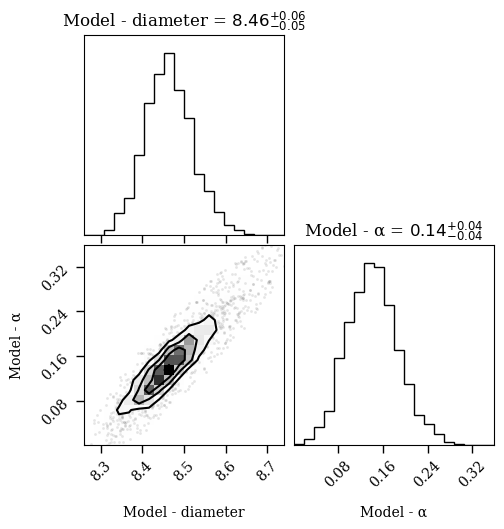

In [19]:
# UltraNest is using Nested Sampling, a global sampling strategy
# It is strictly speaking not a minimizer, but a sampler
# It internally bootstrap the date to obtain robust uncertainties
# It also provides the marginal loglikelihood (log Z), a measure of the model fitness for model comparison purpose
# Larger log Z = better model 
# chi2_geocentric < chi2_heliocentric but logZ_geocentric << logZ_heliocentric
# UltraNest has fun animations when minimizing, better run in from the command line 
minf, minx, cvis_model, result = fit_model_ultranest(data, model, weights=[1.0,0,0]);

In [20]:
# Ultranest result structure contains a lot of useful information
# e.g. the maximum_likelihood parameters, the posterior probability, the boostraping, etc.
result

Dict{Any, Any} with 18 entries:
  "maximum_likelihood"       => Dict{Any, Any}("point"=>[8.4565, 0.135741], "lo…
  "Herr"                     => 0.124455
  "paramnames"               => ["Model - diameter", "Model - α"]
  "logzerr_tail"             => 0.00116511
  "H"                        => 7.54586
  "niter"                    => 6511
  "logz_single"              => -10.6862
  "weighted_samples"         => Dict{Any, Any}("bootstrapped_weights"=>[0.0 0.0…
  "ncall"                    => 9177
  "logzerr"                  => 0.371109
  "logzerr_single"           => 0.137349
  "ess"                      => 1591.17
  "logz_bs"                  => -10.6745
  "samples"                  => [8.45486 0.144047; 8.35585 0.0819603; … ; 8.460…
  "posterior"                => Dict{Any, Any}("median"=>[8.46177, 0.141149], "…
  "logz"                     => -10.6862
  "logzerr_bs"               => 0.371107
  "insertion_order_MWW_test" => Dict{Any, Any}("independent_iterations"=>Inf, "…

In [10]:
# To compute chi2 for a given model
chi2 = model_to_chi2(data, model, weights=[1.0,1.0,1.0], verb=true)

V2: 4.325225621742559 T3A: 8.05483917033522 T3P: 21.79335590721934 

11.391140233099039

In [15]:
# Note how parameter sensitivity is different
chi2 = model_to_chi2(data, model, [8.4,0.1], weights=[1.0,1.0,1.0], verb=true)

V2: 5.467689147723177 T3A: 16.940832470492722 T3P: 5.445364012268678 

9.28462854349486

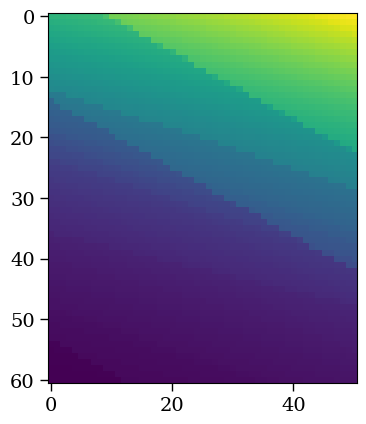

PyObject <matplotlib.image.AxesImage object at 0x7f236259bf40>

In [33]:
# Chi2 maps are easy to make with Julia syntax (grid function coming guess when... Summer 2023)
chi2_map = hcat([[model_to_chi2(data, model, [i,j], weights=[1.0,1.0,1.0], verb=false) for i=8.0:.005:8.3] for j=0.05:0.002:0.15]...)
imshow(chi2_map)

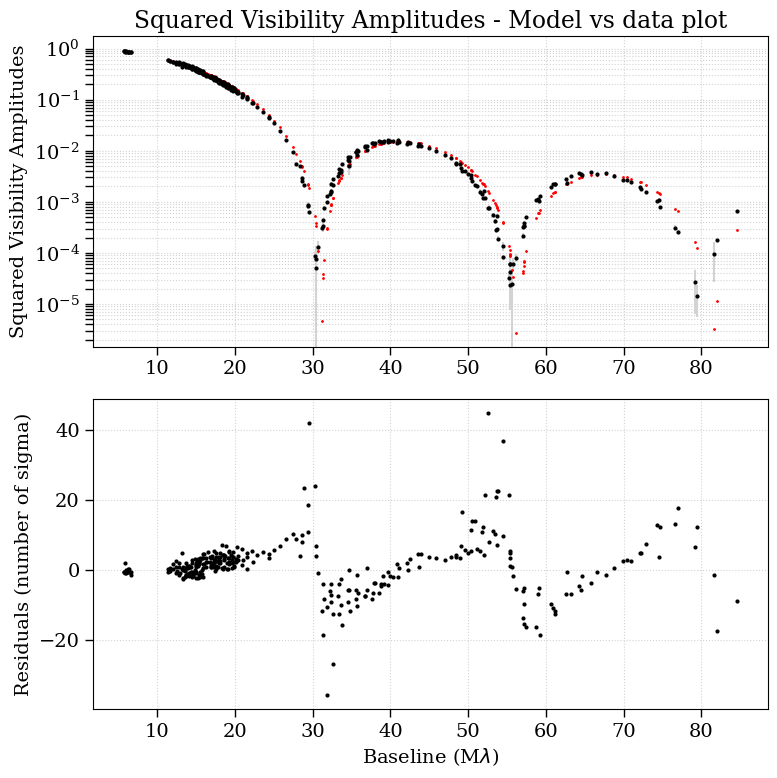

In [34]:
# Compute all model observables (again, diff vis coming soon)
v2_model, t3amp_model, t3phi_model = model_to_obs(model,data);

# Plot model observables vs data (here V2)
plot_v2_vs_data(data, v2_model,logplot=true);

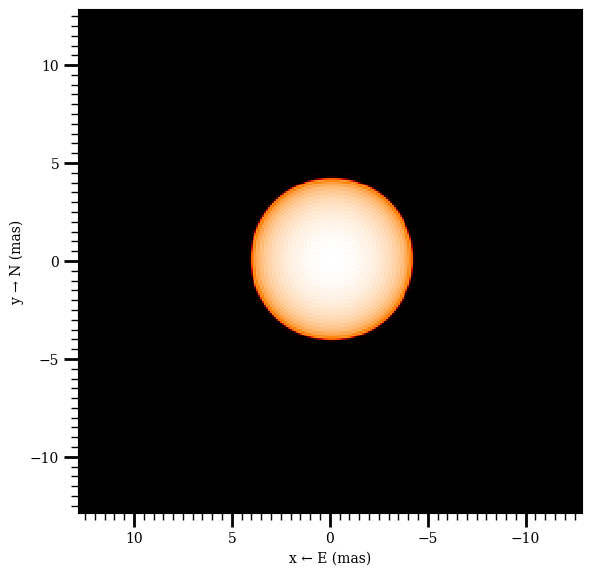

In [24]:
# Visualize the model as an image
img = model_to_image(model, pixsize=0.1)
imdisp(img, pixscale=0.1)

In [25]:
using AstroTime
#Simulate an observation using an analytic model of your target
#In this example, observations start at UT 2018-08-13 at 3:00:00AM and last until 2018-08-13 8:30:00AM, with a period of 15 minutes
dates = collect(from_utc(2018,8,13,3,0,0.0):15minutes:from_utc(2018,8,13,8,30,0.0))

23-element Vector{TAIEpoch{Float64}}:
 2018-08-13T03:00:37.000 TAI
 2018-08-13T03:15:37.000 TAI
 2018-08-13T03:30:37.000 TAI
 2018-08-13T03:45:37.000 TAI
 2018-08-13T04:00:37.000 TAI
 2018-08-13T04:15:37.000 TAI
 2018-08-13T04:30:37.000 TAI
 2018-08-13T04:45:37.000 TAI
 2018-08-13T05:00:37.000 TAI
 2018-08-13T05:15:37.000 TAI
 2018-08-13T05:30:37.000 TAI
 2018-08-13T05:45:37.000 TAI
 2018-08-13T06:00:37.000 TAI
 2018-08-13T06:15:37.000 TAI
 2018-08-13T06:30:37.000 TAI
 2018-08-13T06:45:37.000 TAI
 2018-08-13T07:00:37.000 TAI
 2018-08-13T07:15:37.000 TAI
 2018-08-13T07:30:37.000 TAI
 2018-08-13T07:45:37.000 TAI
 2018-08-13T08:00:37.000 TAI
 2018-08-13T08:15:37.000 TAI
 2018-08-13T08:30:37.000 TAI

In [26]:
# Target info
target = read_obs_file("./data/default_obs.txt"); # read defaults (for OIFITS header)
target.target[1] = "AZ Cyg"
target.raep0[1] =  [20, 57, 59.4437981]'*[1.0, 1/60., 1/3600] # set ra
target.decep0[1] = [46, 28, 00.5731825]'*[1.0, 1/60., 1/3600] # set dec

# Simulation info - can be modified as you wish
facility    = read_facility_file("./data/CHARA_new.txt");
combiner    = read_comb_file("./data/MIRC.txt");
wavelength        = read_wave_file("./data/MIRC_LOWH.txt");

In [27]:
# Error model - very basic
# Tatulli error model (Summer 2023)
# A more complex one is being learned by ML
v2m=1.0/100; v2a=1e-5; t3ampm=1.0/100; t3ampa=1e-6; t3phim=0.0; t3phia=0.5;
errors  = define_errors(v2m,v2a,t3ampm,t3ampa,t3phim,t3phia);

# Output file
out_file="./data/simulation-limb_darkened_disk.oifits";

simulate(facility, target, combiner, wavelength, dates, errors, out_file, model=model);

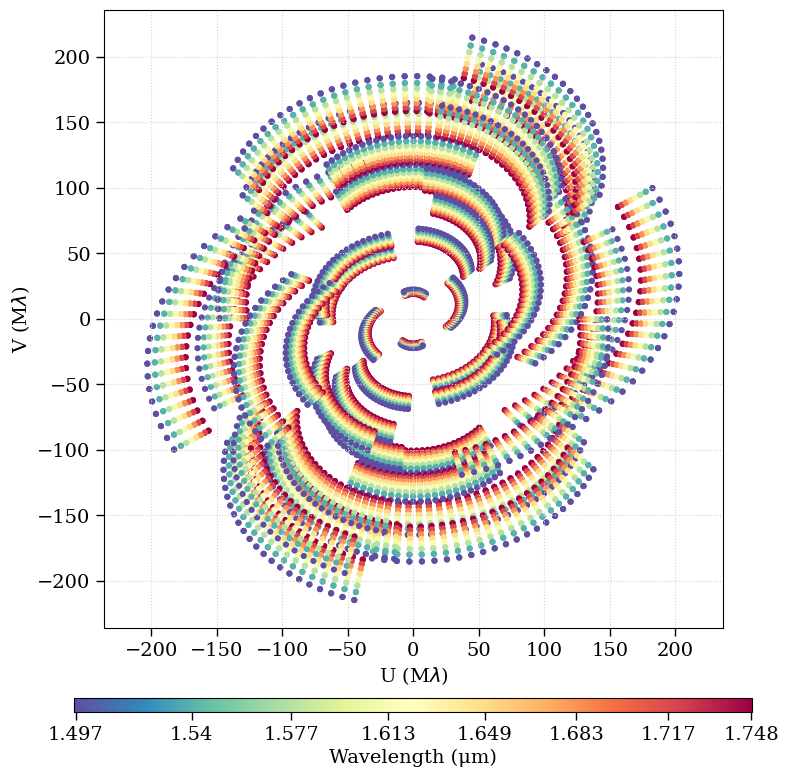

In [32]:
#Check simulated data
data = (readoifits(out_file))[1,1]; # data can be split by wavelength, time, etc.
uvplot(data, color="wav")

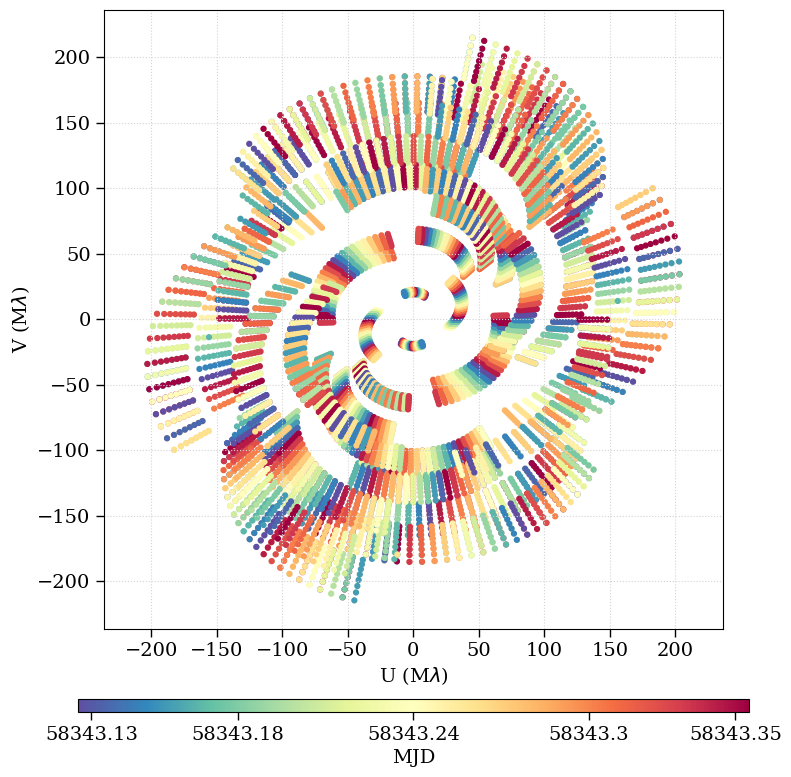

In [33]:
uvplot(data, color="mjd")

In [ ]:
# email all questions to fbaron@gsu.edu
# Contributions & tests welcome